In [1]:
import duckdb
import gc

from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [2]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense,Flatten,Dropout
from keras.optimizers import Adam

2023-11-27 23:08:53.802226: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
con = duckdb.connect(database='jus4.duckdb', read_only=False)

In [10]:
df = con.execute("SELECT * FROM embedding").df()
df.head().to_csv('embedding.csv', index=False)

In [4]:
embedding = con.execute("SELECT * FROM embedding").df()
embedding = embedding.rename(columns={'id': 'seqDocumento'})
embedding

,seqDocumento,data
0,145522785,"[0.19666078686714172, 0.4237271547317505, -0.2..."
1,145501377,"[0.14368093013763428, 0.507375180721283, -0.07..."
2,145496750,"[0.23095284402370453, 0.37697577476501465, -0...."
3,146037675,"[0.22069591283798218, 0.34442731738090515, 0.0..."
4,145049719,"[0.19302083551883698, 0.36576318740844727, -0...."
...,...,...
267,145633556,"[0.16672101616859436, 0.36806151270866394, -0...."
268,143697533,"[0.15580159425735474, 0.44616517424583435, -0...."
269,145050021,"[0.12709838151931763, 0.3970656991004944, -0.0..."
270,145717143,"[0.1537034511566162, 0.4300437271595001, -0.02..."


In [5]:
embedding['matriz_reshaped'] = embedding['data'].apply(lambda x: np.reshape(x, [-1, 768]))
embedding

,seqDocumento,data,matriz_reshaped
0,145522785,"[0.19666078686714172, 0.4237271547317505, -0.2...","[[0.19666078686714172, 0.4237271547317505, -0...."
1,145501377,"[0.14368093013763428, 0.507375180721283, -0.07...","[[0.14368093013763428, 0.507375180721283, -0.0..."
2,145496750,"[0.23095284402370453, 0.37697577476501465, -0....","[[0.23095284402370453, 0.37697577476501465, -0..."
3,146037675,"[0.22069591283798218, 0.34442731738090515, 0.0...","[[0.22069591283798218, 0.34442731738090515, 0...."
4,145049719,"[0.19302083551883698, 0.36576318740844727, -0....","[[0.19302083551883698, 0.36576318740844727, -0..."
...,...,...,...
267,145633556,"[0.16672101616859436, 0.36806151270866394, -0....","[[0.16672101616859436, 0.36806151270866394, -0..."
268,143697533,"[0.15580159425735474, 0.44616517424583435, -0....","[[0.15580159425735474, 0.44616517424583435, -0..."
269,145050021,"[0.12709838151931763, 0.3970656991004944, -0.0...","[[0.12709838151931763, 0.3970656991004944, -0...."
270,145717143,"[0.1537034511566162, 0.4300437271595001, -0.02...","[[0.1537034511566162, 0.4300437271595001, -0.0..."


In [6]:
embedding["matriz_reshaped"][0].shape

(1408, 768)

In [7]:
jurisprudencias = pd.read_csv("count_jurisprudencias0-2000.csv")
jurisprudencias

,seqDocumento,ref,ref_numers,count
0,145522785,t no AREsp 1.621.900/MG,1,2818
1,145501377,t no AREsp. 1.504.312/AL,1,2818
2,145496750,Esp n. 1.740.911/DF,1,2818
3,145496750,1-02.2017.8.26.0576,1,2818
4,145501377,t no REsp 1.816.648/AL,1,2818
...,...,...,...,...
25500,145717236,HC no 0627902-36.2020.8.06.0000,627902,1
25501,146031577,t no AREsp 1816495/RS,1816495,1
25502,146038784,t no REsp 1758267/RN,1758267,1
25503,146038784,t no AgRg no REsp 1580246/RS,1580246,1


In [8]:
ref_encoder = LabelEncoder()
ref_numers = ref_encoder.fit_transform(np.concatenate((['0'],jurisprudencias['ref_numers'].unique())))
ref_numers

array([   0,    1, 2463, ..., 1037,  726, 1439])

In [9]:
ref_encoder.transform(['0'])[0] # valor indica refencia nula

0

In [10]:
n_clusters = ref_numers.size
n_clusters

2832

In [11]:
jurisprudencias['ref_encoder'] = jurisprudencias['ref_numers'].apply(lambda x: ref_encoder.transform([x])[0])
jurisprudencias

,seqDocumento,ref,ref_numers,count,ref_encoder
0,145522785,t no AREsp 1.621.900/MG,1,2818,1
1,145501377,t no AREsp. 1.504.312/AL,1,2818,1
2,145496750,Esp n. 1.740.911/DF,1,2818,1
3,145496750,1-02.2017.8.26.0576,1,2818,1
4,145501377,t no REsp 1.816.648/AL,1,2818,1
...,...,...,...,...,...
25500,145717236,HC no 0627902-36.2020.8.06.0000,627902,1,2341
25501,146031577,t no AREsp 1816495/RS,1816495,1,1170
25502,146038784,t no REsp 1758267/RN,1758267,1,1037
25503,146038784,t no AgRg no REsp 1580246/RS,1580246,1,726


In [12]:
categorias = {}

for documento in jurisprudencias['seqDocumento'].unique():
    subset = jurisprudencias[jurisprudencias['seqDocumento'] == documento]

    matriz = subset["ref_encoder"].unique()
    x = np.zeros((n_clusters),dtype=np.int16)

    x[:matriz.shape[0]] = matriz

    categorias[documento] = x

categorias

{145522785: array([   1, 2463, 2242, ...,    0,    0,    0], dtype=int16),
 145501377: array([   1, 2463, 1645, ...,    0,    0,    0], dtype=int16),
 145496750: array([   1, 2656,    0, ...,    0,    0,    0], dtype=int16),
 146037675: array([   1, 2463, 1645, ...,    0,    0,    0], dtype=int16),
 145049719: array([   1, 2463, 1654, ...,    0,    0,    0], dtype=int16),
 145049704: array([   1, 1176, 2450, ...,    0,    0,    0], dtype=int16),
 146030593: array([   1, 1425, 2796, ...,    0,    0,    0], dtype=int16),
 145613080: array([   1, 2463, 2028, ...,    0,    0,    0], dtype=int16),
 145050015: array([   1, 2463, 2796, ...,    0,    0,    0], dtype=int16),
 144258936: array([1, 0, 0, ..., 0, 0, 0], dtype=int16),
 145067069: array([   1, 2463, 1176, ...,    0,    0,    0], dtype=int16),
 146031591: array([   1, 1676, 2796, ...,    0,    0,    0], dtype=int16),
 145498248: array([   1, 2796,  390, ...,    0,    0,    0], dtype=int16),
 145721738: array([   1, 2463, 1176, ...,  

In [13]:
embedding['ref_encoder'] = embedding['seqDocumento'].map(categorias)
embedding

,seqDocumento,data,matriz_reshaped,ref_encoder
0,145522785,"[0.19666078686714172, 0.4237271547317505, -0.2...","[[0.19666078686714172, 0.4237271547317505, -0....","[1, 2463, 2242, 1425, 1642, 2328, 1754, 2017, ..."
1,145501377,"[0.14368093013763428, 0.507375180721283, -0.07...","[[0.14368093013763428, 0.507375180721283, -0.0...","[1, 2463, 1645, 1676, 1939, 1688, 2420, 2824, ..."
2,145496750,"[0.23095284402370453, 0.37697577476501465, -0....","[[0.23095284402370453, 0.37697577476501465, -0...","[1, 2656, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,146037675,"[0.22069591283798218, 0.34442731738090515, 0.0...","[[0.22069591283798218, 0.34442731738090515, 0....","[1, 2463, 1645, 1643, 1644, 1425, 2136, 1823, ..."
4,145049719,"[0.19302083551883698, 0.36576318740844727, -0....","[[0.19302083551883698, 0.36576318740844727, -0...","[1, 2463, 1654, 971, 945, 0, 0, 0, 0, 0, 0, 0,..."
...,...,...,...,...
267,145633556,"[0.16672101616859436, 0.36806151270866394, -0....","[[0.16672101616859436, 0.36806151270866394, -0...","[1, 2463, 1176, 1644, 2539, 2812, 2567, 17, 0,..."
268,143697533,"[0.15580159425735474, 0.44616517424583435, -0....","[[0.15580159425735474, 0.44616517424583435, -0...","[1, 1920, 476, 2504, 2293, 254, 1925, 118, 222..."
269,145050021,"[0.12709838151931763, 0.3970656991004944, -0.0...","[[0.12709838151931763, 0.3970656991004944, -0....","[1, 2463, 1176, 2656, 390, 271, 286, 2127, 177..."
270,145717143,"[0.1537034511566162, 0.4300437271595001, -0.02...","[[0.1537034511566162, 0.4300437271595001, -0.0...","[2450, 2242, 2216, 2030, 2168, 271, 2768, 2374..."


In [14]:
embedding = embedding.drop(['seqDocumento','data'],axis=1)
embedding

,matriz_reshaped,ref_encoder
0,"[[0.19666078686714172, 0.4237271547317505, -0....","[1, 2463, 2242, 1425, 1642, 2328, 1754, 2017, ..."
1,"[[0.14368093013763428, 0.507375180721283, -0.0...","[1, 2463, 1645, 1676, 1939, 1688, 2420, 2824, ..."
2,"[[0.23095284402370453, 0.37697577476501465, -0...","[1, 2656, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[[0.22069591283798218, 0.34442731738090515, 0....","[1, 2463, 1645, 1643, 1644, 1425, 2136, 1823, ..."
4,"[[0.19302083551883698, 0.36576318740844727, -0...","[1, 2463, 1654, 971, 945, 0, 0, 0, 0, 0, 0, 0,..."
...,...,...
267,"[[0.16672101616859436, 0.36806151270866394, -0...","[1, 2463, 1176, 1644, 2539, 2812, 2567, 17, 0,..."
268,"[[0.15580159425735474, 0.44616517424583435, -0...","[1, 1920, 476, 2504, 2293, 254, 1925, 118, 222..."
269,"[[0.12709838151931763, 0.3970656991004944, -0....","[1, 2463, 1176, 2656, 390, 271, 286, 2127, 177..."
270,"[[0.1537034511566162, 0.4300437271595001, -0.0...","[2450, 2242, 2216, 2030, 2168, 271, 2768, 2374..."


In [15]:
#liberar memoria
del categorias
del jurisprudencias
del ref_numers
gc.collect()

43

In [16]:
y = np.zeros((embedding['ref_encoder'].size,n_clusters),dtype=np.int8)

for i,e in enumerate(embedding['ref_encoder']):
  y[i][e] = 1
y

array([[1, 1, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]], dtype=int8)

In [40]:
x = np.zeros((embedding['matriz_reshaped'].size,2500, 768),dtype=np.float16)
# Iterar sobre cada matriz em matriz_reshaped
for i,matriz in enumerate(embedding['matriz_reshaped']):
  x[i,:matriz.shape[0], :] = matriz

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import gaussian_kde

data = x

# Suponha que 'data' é seu array original com a forma (30, 100, 60)
# Você precisa transformar isso em três vetores 1D para x, y e z
data_reshaped = data.reshape(3, -1)
x, y, z = data_reshaped

# Aplicando KDE nos dados remodelados
kde = gaussian_kde(data_reshaped)
density = kde(data_reshaped)

# Plotando os dados com densidade
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Os pontos serão coloridos com base na densidade
scatter = ax.scatter(x, y, z, c=density, cmap='viridis')

# Adicionando uma barra de cores para representar a densidade
fig.colorbar(scatter, ax=ax, label='Density')

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_title('3D Scatter Plot with Density Coloring')

plt.show()

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

data = x

# Suponha que 'data' é seu array original com a forma (n_samples, n_features)
# Por exemplo, pode ser um array (1800, 3) se você remodelar seu array (30, 100, 60)

# Aplicar PCA para reduzir a dimensionalidade para 3
pca = PCA(n_components=3)
data_transformed = pca.fit_transform(data)

# Separando os componentes principais
x = data_transformed[:, 0]
y = data_transformed[:, 1]
z = data_transformed[:, 2]

# Aplicando KDE nos dados transformados
kde = gaussian_kde(data_transformed.T)
density = kde(data_transformed.T)

# Plotando os dados com densidade
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Os pontos serão coloridos com base na densidade
scatter = ax.scatter(x, y, z, c=density, cmap='viridis')

# Adicionando uma barra de cores para representar a densidade
fig.colorbar(scatter, ax=ax, label='Density')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D Scatter Plot with PCA and Density Coloring')

plt.show()

In [39]:
from scipy.stats import gaussian_kde

# Reaplicando KDE
kde = gaussian_kde(data)

# Calculando a densidade em cada ponto novamente
density = kde(data)

# Plotando os dados com densidade
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Os pontos serão coloridos com base na densidade
scatter = ax.scatter(x, y, z, c=density, cmap='viridis')

# Adicionando uma barra de cores para representar a densidade
fig.colorbar(scatter, ax=ax, label='Density')

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_title('3D Scatter Plot with Density Coloring')

plt.show()

ValueError: too many values to unpack (expected 2)

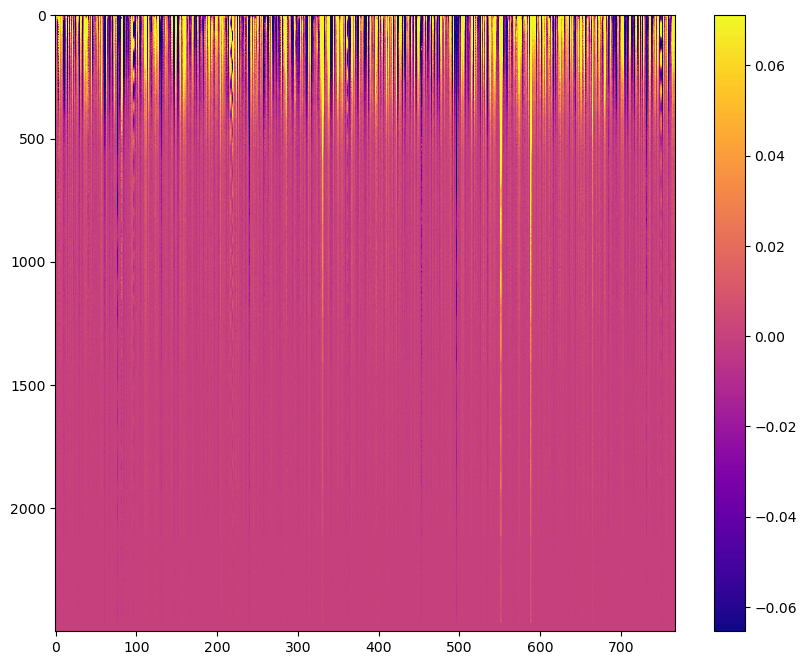

In [27]:
import numpy as np
import matplotlib.pyplot as plt

data = x

# Calcular a média ao longo da primeira dimensão (200)
mean_data = np.mean(data, axis=0)

# Ajustar a escala de cores para aumentar o contraste
# Podemos fazer isso definindo os limites do colormap para uma faixa mais estreita centrada em torno da média
mean_val = np.mean(mean_data)
std_val = np.std(mean_data)
lower_bound = mean_val - std_val
upper_bound = mean_val + std_val

# Criar o gráfico de calor com a escala ajustada
plt.figure(figsize=(10, 8))
plt.imshow(mean_data, aspect='auto', vmin=lower_bound, vmax=upper_bound, cmap='plasma')
plt.colorbar()
plt.show()

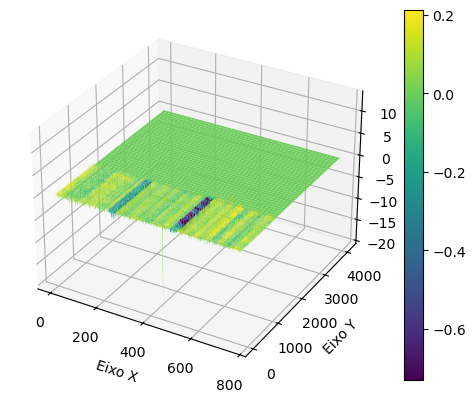

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

# Suponha que data seja o seu array com a forma (200, 4096, 768)
data = x

# Escolha um slice dos dados para a visualização
slice_data = x[0]  # Vamos usar a primeira "camada" dos dados como exemplo

# Crie as coordenadas X e Y para o gráfico 3D
x = np.arange(4096)
y = np.arange(768)
X, Y = np.meshgrid(x, y)
Z = slice_data

# Crie a figura 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Crie o gráfico de superfície 3D
surf = ax.plot_surface(X, Y, Z, cmap='viridis')

# Adicione uma barra de cores para indicar os valores
fig.colorbar(surf)

# Rotule os eixos
ax.set_xlabel('Eixo X')
ax.set_ylabel('Eixo Y')
ax.set_zlabel('Eixo Z')

# Exiba o gráfico
plt.show()

In [18]:
del embedding
del e
del matriz
gc.collect()

0

In [19]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [20]:
del x
del y
gc.collect()

0

In [21]:
x_train_tensor = tf.convert_to_tensor(x_train, dtype='float16')

del x_train
tf.compat.v1.reset_default_graph()
gc.collect()

x_train_tensor

2023-11-27 11:40:02.517513: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


<tf.Tensor: shape=(217, 4096, 768), dtype=float16, numpy=
array([[[ 0.2705  ,  0.4307  , -0.03226 , ...,  0.0837  , -0.1849  ,
          0.06915 ],
        [ 0.2043  , -0.05145 , -0.04504 , ...,  0.05658 , -0.2166  ,
         -0.2693  ],
        [ 0.0936  ,  0.3496  , -0.1348  , ...,  0.6646  , -0.2812  ,
         -0.0237  ],
        ...,
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ]],

       [[ 0.313   ,  0.3684  , -0.02411 , ...,  0.21    , -0.05554 ,
          0.07556 ],
        [ 0.4243  ,  0.2213  , -0.02304 , ...,  0.232   ,  0.02417 ,
         -0.1537  ],
        [ 0.4448  ,  0.3171  ,  0.2142  , ...,  0.572   , -0.0892  ,
          0.03842 ],
        ...,
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.  

In [22]:
y_train_tensor = tf.convert_to_tensor(y_train)

del y_train
tf.compat.v1.reset_default_graph()
gc.collect()

y_train_tensor

<tf.Tensor: shape=(217, 2832), dtype=int8, numpy=
array([[1, 1, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0]], dtype=int8)>

In [23]:
x_test_tensor = tf.convert_to_tensor(x_test)
y_test_tensor = tf.convert_to_tensor(y_test)

del x_test
del y_test
tf.compat.v1.reset_default_graph()
gc.collect()

0

In [24]:
model = Sequential()
model.add(Flatten(input_shape=(4096, 768)))
#model.add(Dropout(0.97))
model.add(Dense(64,activation='tanh'))
model.add(Dense(64, activation='tanh'))
model.add(Dense(64,activation='tanh'))
model.add(Dense(64, activation='tanh'))
model.add(Dense(n_clusters, activation='softmax'))

model.compile(optimizer=Adam(), loss='categorical_crossentropy',metrics=['acc'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3145728)           0         
                                                                 
 dense (Dense)               (None, 64)                201326656 
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 2832)              184080    
                                                                 
Total params: 201,523,216
Trainable params: 201,523,216


In [25]:
model.fit(x_train_tensor,y_train_tensor, epochs=700, batch_size=64,verbose=1)

Epoch 1/700
4/4 [==============================] - 19s 4s/step - loss: 95.4558 - acc: 0.3226
Epoch 2/700
4/4 [==============================] - 16s 4s/step - loss: 93.1932 - acc: 0.9447
Epoch 3/700
4/4 [==============================] - 16s 4s/step - loss: 90.2813 - acc: 0.9770
Epoch 4/700
4/4 [==============================] - 17s 4s/step - loss: 86.9737 - acc: 0.9908
Epoch 5/700
4/4 [==============================] - 17s 4s/step - loss: 83.6397 - acc: 1.0000
Epoch 6/700
4/4 [==============================] - 18s 5s/step - loss: 80.7661 - acc: 1.0000
Epoch 7/700
4/4 [==============================] - 22s 5s/step - loss: 78.4052 - acc: 1.0000
Epoch 8/700
4/4 [==============================] - 22s 5s/step - loss: 76.5908 - acc: 1.0000
Epoch 9/700
4/4 [==============================] - 23s 6s/step - loss: 75.2446 - acc: 1.0000
Epoch 10/700
4/4 [==============================] - 23s 6s/step - loss: 74.1340 - acc: 1.0000
Epoch 11/700
4/4 [==============================] - 23s 5s/step - los

In [26]:
# Avaliando o modelo
loss, accuracy = model.evaluate(x_test_tensor, y_test_tensor)
print(f"Perda: {loss}, Acurácia: {accuracy}")

2/2 [==============================] - 2s 665ms/step - loss: 748.7899 - acc: 1.0000
Perda: 748.7898559570312, Acurácia: 1.0


In [27]:
model.save('64-64-64-64.h5')

In [ ]:
con.close()